# Description

### This script uses DeepLabCut-derived data to detect freezing responses. We only use the .csv (you need to opt for it during DLC analysis) and .pickle output of DLC, not the .h5 files. The parameters which are set here are adjusted based on the training model, which in turn is based on the quality of the video, the fps and the experimental environment. These parameters should suffice for the detection of freezing in other experimental settings, given that their values are adjusted accordingly. In order to adjust the parameters appropriately, the user has to inspect some indicative freezing as well as moving frames. More details will be given below.

A few terms that are useful for the understanding of functions :<br><br>
Let detection variance be the difference between frame x1 and x2 and frame y1 and y2 for axes x and y, respectively, for a particular bodypart (i.e betwears). We refer to this difference as detection variance only when it is a result of low likelihood estimations of DLC (and not on real differences due to actuall movement). That is, when the likelihood value of a frame is low, it means that DLC cannot detect that confidently the exact position of a bodypart, hence the detection variance may increase. <br><br>
Let's define moving frames as the frames where a mouse is moving, and that is condirmed by eye.<br><br>
The detection probability is the same as likelihood, as indicated in DLC output files.


## Succession of functions 

### 1) GatherCsvFiles() will read all important information 
a) the interpreted 'csv' file that contains coordinates for all columns, b) 'fps', c) 'bodyparts') d) an empty list 'lowlikeli' that will be later on filled with frames of low likelihood and e) a 'short' variable that will be later on replaced with an int in case a video is shorter than expected. GatherCsvFiles() eventually creates a dict with these info for each file.
### 2) CreateExceLog will later on create an excel file indicating ranges of freezing that have been excluded from final freezing due to some user's cut-off criteria (see explanation of ExceLog at the end of the description). 
Note that CreateExceLog does not work optimally yet. It's preferable to investigate False Negatives by investigating the python lists that contain the excluded ranges directly.
### 3) TrimFrames() is used to isolate a time window of interest by trimming the edges (start/stop). 
It hasn't been tested thoroughly. Therefore, it's preferable to have your videos trimmed already.
### 4) LocateUncertainFrames() detects frames with 'low' detection probability as determined by DLC. 
These frames will be then linearly interpolated based on one certain -high detection probability- frame on the left (earlier in time) and one certain frame on the right (later in time). Of note, the 'low' detection probability frames only fall within a specified range. Frames with probability/likelihood lower than this range are not interpolated on purpose. The reason that very low probability frames are not of intereste is : <br>

1) Frames with really low probability will display bigger frame by frame tracking variance, therefore unlikely to be used for detection of a freezing response

2) The longer the accepted range of low probability is, the more frames are deemed as uncertain, hence included in the interpolation. As a result, the moving frames can be subjected to linear interpolation, therefore being 'smoothed' too. This can be very problematic since by smoothing/interpolating the moving frames (in a long series of uncertain frames surrounded by 2 certain frames), their distance can be erroneuously reduced. Hence, real moving might not be detected. Moreover, chances that the certain (high probability) frame following the uncertain frames will delay to appear are increased. That is, the animal might move (and especially the very high values in this case) but the detection probability will still be low, based on our cutoff criteria. As a result, interpolation will delay. We want to limit the interpolation's range so that we approach the real values instead of 'oversmoothing'.

The interpolation itself is very important and can be applied in cases where the bodypart cannot be tracked by DLC very precisely, provided that the detection probability value falls within the accepted interpolation range. Without interpolation, the detection variance per frame is oftentimes high enough to obscure freezing. Luckily, in the vast majority of cases, even a slight movement of the animal following freezing will lead to an increased detection probability. Therefore, this moving frame of high probability is used as the right edge for the linear interpolation (certain frame on the right side). Consequently, the previous freezing frames with variance higher than the accepted one will now be smoothed, hence considered as freezing frames.

Technical notes :

1. At this point the code, frames are not categorized to chunks yet based on their adjacency. The output (dictionary with bodyparts as keys and a list with int corresponding to frames as value) value of the dictionary is just a long list with all frames that fall within the accepted interpolation range regardless their contiguity. 

### 5) InterpolateLowLikelihoodFrames() will take the input from LocateUncertainFrames() and create series of adjacent low probability frames (provided that these series exist). These values will be then linearly interpolated. 
The new interpolated values will replace the old ones within the 'csv' dataframe itself, which was initially created in GatherCsvFiles(). The frames that are not shaping contiguous chains will also be interpolated as single frames, based on their adjacent certain frames on the left and on the right. Here is a simplified example of interpolation, with the green (certain) and the orange (uncertain frames), for a series of adjacent low probability frames.

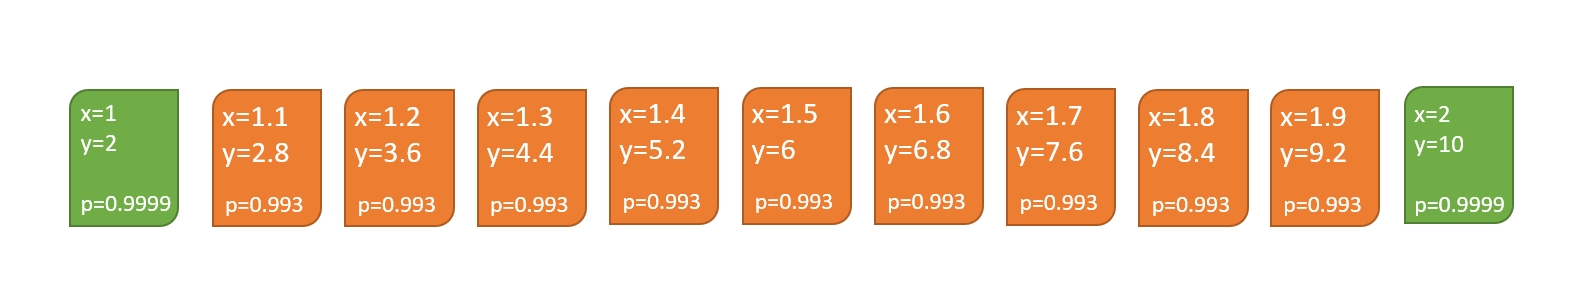




Technical notes:

1. The first part of the function categorizes the frames of accepted uncertainty based on their contiguity. If they are adjacent, they go together in a list. If not, they for a list[one element]. (This is the make chunks of consecutive frames within range part). Then, interpolation takes place based on the size of the list-chunk (one element or more).

2. The interpolation for single frames is just the avg of the surrounding high likelihood frames.

3. For the interpolation of a chain of frames, the high likelihood surround frames from left and right must be included in the linspace method. That's why we do linspace_len + 2. This is also the reason we used [1:-1] in the intermediate_X_vals = np.linspace(prev_Xcoord,next_Xcoord,linspace_len+2)[1:-1]. When changing the values of the series, we just want to change the ones within the accepted uncertainty range and not the rest.

6. Mind that a + 2 correction is used for index in the pandas series  ( fst_digit= CHUNK[0]+2 , lst_digit = CHUNK[-1]+2 ). This is because we haven't set_index('scorer') yet. This only happens in DetectFreezingRanges().

7. I write first_digit (and fst_digit respectively) < 3 to prevent a situation where the 'likelihood' itself is taken as value instead of a real value. If the assignment (definition) of first_digit or fst_digit changes, then 3 has to change too.


### 6) MakeValuesFloat() will just change the type of values to float.


### 7) DetectFreeezingRanges() will realize the first estimation of freezing frame series (ranges). 

Some important parameters here (also mentioned in description of the function) : <br><br>

loc_diff -> cutoff criterion for the x+y axis difference of two consecutive frames. If |x1-x2| + |y1-y2|  is larger than the cutoff criterion, this is an indication of moving. A difference lower than the cutoff criterion is an indication that we have spotted the start of a freezing response. Note that both for locating the start as well as the continuum of freezing, as second parameter is inserted, this is described in the next paragraph.

When having found a start of freezing and sliding across following frames, if moving is detected (that is, there is a difference between two frames that is higher the cutoff criterion), it needs to be validated first. If this cutoff criterion was the only criterion to determine freezing, then we would encounter many false negatives. The reason is that cutoff criterion can be violated even in occassions of real freezing, due to the detection variance. Therefore, another validation parameter is inserted, that is avged_diff. The way avged diff is calculated is explained in the function's description. The idea behind this concept is that, given that there is real freezing, even if the distance between two frames exceeds the cutoff criterion due to detection variance, this detection variance should be attenuated if we take into account more adjacent frames. Afterall, start of moving cannot only last one frame (fps = 25 in our case), thereby if moving was real, we should see continuous violations of the cutoff criterion. If we only see one violation, it can be attributed to detection variance per se, thereby rectified and considered as freezing. Below a simplified example of how avged_diff works : 

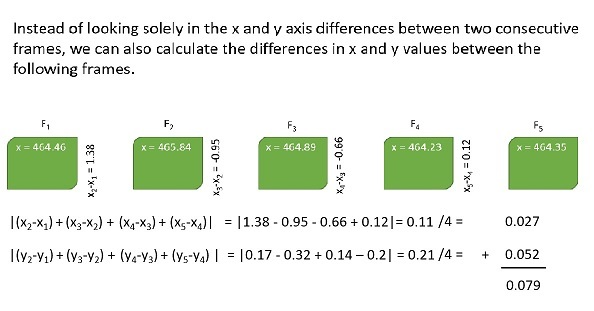


Notes: increasing loc_diff can improve detection accuracy till the last freezing frame but it might make freezing detection too liberal in some cases. Therefore it needs to be adjusted with caution. Similarly for the avged_diff. 

Technical notes : 

1. The denominator used for the calculation of avged_diff in  DetectFreezingRanges() and EarFreezingRanges() was 4. This number was not intuitive. This doesnt mean it's wrong, because there's not right and wrong, it's just a value we come up with. However, it should preferably be like this : The denominator_ff ( ff = future frames) must change to future_frames-1 because the current frame is not taken into account for the calculation of avged_diff of the future frames. The -1 comes for the fact that we are dividing the differences between adjacent frames, which means by defaults that these differences will be less by one compared to the frames in terms of numbers. 

2. When we .set_index('scorer') to rectify for wrong indexing, this change takes place not only inside the function but also outside, because pandas series and dataframe is mutable. Practically, we perform a change to the object itself and the [csv] of the dfmeta changes itself. Therefore, from this moment onwards the all_files[filename]['csv'] is changed.

4. Note October 2024 checkpoint 30 : Previous versions used to have a past_frames variable too for the initial calculation ofthe starting point also based on avged diff of previous frames. This has been depracated. The denominator['pf'] can be removed from the script.

6. With respect to the minimum number of consecutive freezing frames needed for the behavior to be considered as freezing, it is set to 47 instead of 50 (which corresponds to 2 secs) on purpose. The reason for this is that the RectifyStartFreezingTime() can look a few frames back from the initial freezing frame and include more frames as 'freezing' ones, if the user wants to apply more loose criteria for the starting point of a freezing behavior particularly. Therefore, 47 freezing frames could be 50 if the preceding 3 frames are now included based on the user's criteria. This is set by the user_rect_loc_diff, which is practically eliminated if it is smaller than loc_diff, since it won't include further freezing frames.

7. The value of each denominator is saved along with the denominator-variable name(i.e {'denominator_ff':number}. Then, the whole dict is 'passed' a nested dict to one the keys of the dfmeta['denominators']. In this function, it should be : df['denominators']['betwears'] that eventually has a value like this {'denominator_ff':number, {'denominator_Pf':number}. This information will be used for creating video labels based on another script.

8.  Some additional lines of code apply for the occasion where avged_diff (which is calculated of course starting on a reference frame x1y1) exceeds the cut-off criterion ONLY when calculated for frame x1y1 and not when calculated starting from the following ones. <br><br>
Everytime that avged_diff is violated, we also look at the avged_diff that the next frame would have and if it's not violated too, then freezing continues. This reduces False Negatives since it's unlikely that avged_diff is high for frame x1y2 and then low again for starting/reference frame x2y2.<br><br>
To make sure that it won't introduce false positive frames in the start of a freezing behavior, this only applies after the first freezing frames (future_frames/2)<br>


To be changed in future :

1. Keep in mind that if you want to change the future_frames, the RectifyStartFreezingTime must also change because its range of looking back for detecting the first frame is limited. This concerns not only the DetectFreeezingRanges() but also the EarFreezingRange() and NoseandHosed().





### 8) RectifyStartFreezingTime()
 
New note on October 2024 : The RectifyStartFreezing will only now work if the loc_diff set is larger than the loc_diff for betwears or second bodypart. Otherwise, it is eliminated.

This function will increase precision in detecting the starting time and if it turns out that the starting time of a freezing series is actually 50 (corresponding to 2 secs for 25 fps) instead of, let's say 47 frames, then the freezing response will be included to the new list with potential (still not established) freezing responses. This function is complementary to DetectFreezingRanges. This is the reason the the min_frames in the DetectFreezingRanges is slightly less than 50 (for 2 seconds minimum freezing) or less than 25 (for 1 second minimum freezing) in 25 fps videos.

### 9) EarFreezingRange()

This is similar (but not same) to the DetectFreeezingRanges() and it's used as a second attempt to spot further freezing responses. Especially in videos of lower quality, the primary region of focus (between ears [betwears] in this case) can display low detection probability, thus high detection variance. By utilizing another body part this problem can be resolved. Here, I have selected the 'right' ear as a complentary body part because the source of light was chiefly coming from the left in my setup. This means that when mice are turned towards the left, the detection of betwears will be good enough (high prob, low variance), whereas when they are turned towards right, the detection will slightly decrease. However, the right ear will still be clear enough to detect with high likelihood. When likelihood is small for betwears -hence detection variance higher- it can still be large for right ear -hence detection variance lower-. Of course, it is by itself a discrepancy if we take into account series of freezing responses based on 2 bodyparts which do not display freezing concomittantly. However, it has been so far reliable to do so given the inherent problems of low quality videos (also see technical notes 3). Many False Negatives have been rescued by using this technique and only a small amount of False Positives is inserted. The NoseAndHosed() function helps for that because it eliminates freezing frames (based on betwears or right ear) when motion in the nose is detected. 

Technical notes

1. I only append the freezing series of the right ear if they -practically- don't overlap with the betwears freezing. I only give a leeway of 3 frames overlap (which is just 3/25 of a second) because start and stop is sometimes varying a few frames. However, I have encountered some rare cases where freezing starts in right ear and it continues in both rightear and betwears a few secs later. In this circumstance, betweers detection likelihood was lower and detection variance was high, thereby not spotting freezing from the start.<br>
Of course, I want to include the preceding rightear freezing that was not detected by betwears. To do so, I have inserted the elif statement at the end of the function, whereby the right ear freezing will be finally included in the list with freezing responses if the first 25 frames of it (remember it has to be at least 50 for 2 secs minimum freezing) do not overlap with any frames from a betwears freezing response. 
When using using user_frms_cutoff=25 (that is, a minimum of 25 frames of no motion to be considres as freezing, or 1 second), the user_frms_cutoff inside elif will be 25/2 rounded, that is 12 , which is half of a second.

2. If you want to set the freezing cutoff criterion to less that a second of freezing, read this comment  and locate it in the function 'In case you want to reduce freezing cutoff criterion to less than a second, consider making changes below. Inside the function'.


3. Mind the whole_range_prob argument. For this function particularly, one more filter is added. Even if the avged_diff does not surpass the cutoff criterion, the freezing range will only be considered as freezing if the detection likelihood of this range is large enough. This way, we ensure that the additional freezing that we spot based on the ear does not introduce many false positives. The excluded range will be added to ExceLog.


### 10) NoseandHosed()

Here the nose is used to detect motion in series that have been so far considered freezing, based on either betwears or right ear freezing detection. Note that the default arguments will take into account the 'nose' as a checker and the freezing ranges from 'betwears' as freezing ranges. When the freezing ranges of rightear are used, the range_vals parameter for the right ear freezing -or the bodypart of your own choice- need to be passed to replace the default value. To detect motion in nose we use similar parameters as described above, that is loc_diff and avged_diff. Again, the user has to spot cases of slight nose movement and tweak the parameters to see what fits best. It is a procedure that will require sometime. It is suggested that frames of nose motion are collected from different videos. It should be stressed here that in order motion of nose to be considered real, another parameter is inserted, that is prob_cut. The averaged probability of N consecutive 'moving' frames based on the nose is taken into account and if it is lower than the prob_cut, then the motion in nose will be neglected, hence not used to exclude a freezing behavior according to betwears or rightear. We can only rectify freezing if we are sure that the nose is moving. Otherwise we will get many False Negatives. When NoseandHosed() verifies nose motion, it will raise some flags, which are frames suspicious of real movement. Note that there are default values not only for range_vals but also for prob_cut that apply for betwears. I change them for right ear detection. 

Technical notes : 

1. For the detection of moving frames : 1st will check loc_diff. Second, if no motion is detected will check avged_diff (using future_frames). Third, if motion is observed will check if the mean of the following frames (prob_cut_frames) is high enough to pass the filter (higher than prob_cut) and only then will raise a flag. Don't mistake future frames with prob_cut_frames. They are both frames in the future but one is for avged_diff and the other for probability.


### 11) ChainProximalMovingPoints()
ChainProximalMovingPoints() will read these flags and create series of suspicious frames if flags are close to each other. The accepted proximity of left (earlier in time) and right (later in time) flags to create a chain of contiguous freezing frames between these two is defined by the motion_proximity parameter -which we usually not change. Note that the default freezing range here is again for the betwears ('freezing_ranges') and it has to be changed to 'earfreezing' for the right ear. The rationale here is that if suspicious variance (corresponding to movement) has been detected, it should be detected more than once between frames that are temporally close (how close? this is defined by the motion_proximity parameter). The detection itself is many times insufficient to detect all moving timepoints based on the afforementioned parameters that we've set, thereby the 'gaps' between the flags will be filled. Thus, if there is motion detected in frame 534 and frame 538, a chain 534,535,536,537,538 will be created. This chain is indicative of motion. At least that's how we treat it.<br>
An additional parameter has been of use for some experimental settings, that is user_betwnose_nextflag_diff. It helps to insert more easily a second flag on the next frame, given that the previous frame was a flag itself. How? It practically replaces the avged_diff value that is set for nose movement with smaller one, meaning that it's now easier for nose to be considered as moving. Therefore, it makes criteria of moving for nose more loose. It's purpose is to reduce false positive freezings. It's not permanently replacing the avged_diff. It only applies after a first flag (nose moving frame) has been detected in order to evaluate the next one.

### 12) RemoveChains()

This function will eventually remove the already created chain(s) from the broader freezing response. If the remaining frames do not complete series of at least 50 (50 is an example of user frames cutoff) consecutive frames, then they will be completely removed. Thereby, if we have 3 secs of freezing and motion is detected on 2nd sec, all frames will be erased from freezing responses (with a min_frames criterion of 50). Based on the former example on ChainProximalMovingPoints(), 534,535,536,537,538 will be turned to _,_,_,_,_, in the broader freezing range. For instance : 522,523,524,525,526,527,528,529,530,531,532,533,_,_,_,_,_,539,540,541,542. What precedes the first _ is not large enough to be considered a freezing response. Similarly for what follows the last _.

### 13) DetectStartingPoints()

It's used twice for betwears (and twice for right ear too). This is used to facilitate validation of starting points of freezing. Each time, it is first used to detect starts of freezing preceding the nose detection & corection, and then to give the starting time of the final freezing durations. Some users might find this helpful for their experiments although we haven't really used. I prefer looking directly on the freezing frame numbers in the final lists including freezing (all_first_finals & all_second_finals) and then navigate to the respective frame on the labelled videos (see script for labelling) to investigate freezing.

### 14) Save freezing to csv

The user_bins variable defines the number of bins that will be created after analysing your freezing frames. For instance, here I select 120, which corresponds to 5 seconds per bin for 10 minute videos (600 seconds). Just run the cell following the main code to create a csv file. You will be asked to name it. You don't have to add the .csv extension in the filename

### 15) Save pickles for labelling videos

After you get your freezing data, you can save all necessary parameters that were used in this code so that you can use them afterwards to create labels in your raw videos. These labels include calculations of loc_diff, avged_diff and likelihood for each single frame. All frames in your videos will also include a label with their number. When freezing is detected for betwears, the label '1st_freezing' should appear on the screen, whereas freezing is detected for 2nd_bodypart, the label 2nd_freezing should appear on the screen. Mind that these pickle files are not the same as the ones from DLC output. These are pickle files specifically for the output of this code. Store them all in a path so that you can use them for labelling. <br?>
Tip: You can use the labelling script after setting some really rough values for the parameters in this code. The labelled videos will help you select much more efficiently the right values since you'll be able to estimate the right values by looking directly on the video instead of the csv output of DLC.

### Other remarks

The training model included roughly 15 mice and a second iteration was implemented. During the first training, I was too liberal on marking the nose whereas I was more parsimonious on the second one and I would leave it unlabelled if not clearly visible. I did similarly for ears and betwears although betwears was pretty much always apparent. For the betwears, I was targetting the line between the ears on their front, that is the part closer to the nose. I would imagine that a vertical line connects the anterior edges of the base of the ear (not the high part of the ear) and in the middle of that line I would place the label. I also try to have the label as perpendicular to the nose as possible. The parts that I labelled were : betwears (between ears), right and left (ear) and nose.


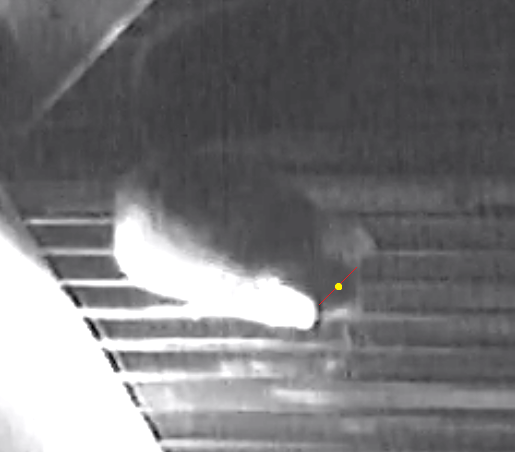

### Explanation of ExceLog

The freezing ranges that are eventually excluded from the final results are registered to a dataframe (ExceLog) that can be saved as csv file. The user can use this file to identify contingent False Negatives and re-adjust the values of several parameters. 
Every column of the ExceLog corresponds to a file name from DLC output. The logging takes place inside several functions, depending on the parameter used for exclusion. Every time an exclusion takes place, it is registered to a particular subcolumn.

Explanation of subcolumns :

Rej. by average likelihood -> The mean likelihood for the secondary body part detection when all freezing points of a freezing range are taken into account. This filter is following avged_diff and does not exist for the primary detection based on betwears but it's used for the secondary body part detection. The second bodypart can only be taken into account if more strict criteria are applied. Otherwise it's not complementary but it might antagonize the betwears detection. The numbers submitted under this subcolumn correspond to the starting and end point of an excluded freezing range.

Rejected by Nose movement -> Nose movement is used as an additional criterion for filtering after betwears or betwears + second body part detection. The numbers submitted under this subcolumn correspond to the starting and end point of an excluded freezing range. 
Note that in cases where the set of flag '_' symbols is in between a freezing response (practically almost in all cases) like this example : [14773, 14774, 14775, 14776, 14777, 14778, 14779, 14780, 14781, 14782, 14783, '_', '_', '_', '_', '_', '_', '_', 14791, 14792, 14793, 14794, 14795, 14796, 14797, 14798, 14799, 14800, 14801, 14802, 14803, 14804, 14805], the starting point 14773 will be registered succesfuly with an end point to 14783. However, more optimizations will take place here in the future because the registration 14791 as a starting point and 14805 as ending point might not take place.



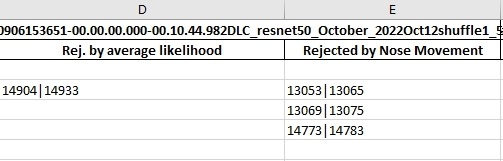

In [27]:
import pandas as pd
import numpy as np
import datetime
import sys
import copy
import datetime
import json
import itertools
import plotly.express as px
import regex as re
from os import listdir
from os.path import isfile, join
from collections import defaultdict    
import pickle

In [28]:
def GatherCsvFiles(files) :
    """ Input 'files' : List with strings representing independent files in a directory as elements
        Output : Dictionary :
                    keys    : each file's name 
                    values  : Dictionary
                                 keys   : csv, fps,     bodyparts,                 lowlikeli,           short
                                           ||  ||          ||                         ||                  ||
                                           \/  \/          \/                         \/                  \/
                                 values :  df ,float, list (with str as elements), list (empty for now), None
        
        Creates a dictionary with that contains all csv files and their fps and bodyparts info. An empty 'lowlikeli' value
        is also created. This will be used in LocateUncertainFrames() to include frames with low likelihood of successful detection.
        The 'short' key has by default a None value which will become an int value during TrimFrames() if the duration of the trial
        is less than expected.
        
        Example of an output with only one file in the directory -> 
        {'A02_20220426152400DLC_resnet50_20_August_2022Aug19shuffle1_500000.csv' : {a whole df, 'fps':25.00057764735784, 
        'bodyparts': ['betwears', 'tailbase'], 'lowlikeli':[],'short':None} ... }"""
    
    df_and_meta = {}
    for file in files :
        if '.csv' == file[-4:] :
            csv = pd.read_csv(join(path,file))
            pickle_path = join(path,file[:-4]) + '_meta.pickle'
            try :
                pd.read_pickle(pickle_path)
            except FileNotFoundError :
                print('The pickle file appears to be missing. ' \
                      'Make sure that there is a \'_meta.pickle\' file in the same directory as your csv file. \n' \
                      'Also make sure that filenames are identical (except for the \'_meta.pickle\' part which replaces .csv). \n' \
                      'The file {file} will not be included in the analysis. \n'.format(file=file))
                continue 
                
            # given that there is a properly named pickle file (see above)     
            try :
                metadata = pd.read_pickle(pickle_path)
                fps = metadata['data']['fps']
                bodyparts = metadata['data']['DLC-model-config file']['all_joints_names']
            except :
                print('Either fps or bodyparts could not be extracted from the _meta.pickle file. \n' \
                'Make sure that the file is not corrupted and deeplabcut metadata pickle files have not changed their format'\
                 'The file {file} will not be included in the analysis. \n'.format(file=file))
                continue
            
            # given that there is a proper content of that pickle file (see above)
            df_and_meta[file] = {'csv':csv,'fps':fps,'bodyparts':bodyparts, 'lowlikeli' :[], 'short': None}
                    
    return df_and_meta

In [29]:
def CreateExceLog (files) :
    """ Input files : The output of GatherCsvFiles -> 
    Dictionary :
                    keys    : each file's name 
                    values  : Dictionary
                                 keys   : csv, fps,     bodyparts,                 lowlikeli,           short
                                           ||  ||          ||                         ||                  ||
                                           \/  \/          \/                         \/                  \/
                                 values :  df ,float, list (with str as elements), list (empty for now), None
        
        Output : A global variable that is an excel file to log particular circumstances.
        
        This function creates an excel file where some excluded freezing ranges will be recorded from within other functions.
        
        The 'Rej. by average likelihood' refers to the excluded freezing ranges due to low mean likelihood of 
        the whole range after satisfying the criteria for freezing based on avged_diff. 
        These ranges are excluded from freezing and added to this excel in EarFreezingRange().
        """
    global ExceLog
    
    all_mouse_ids_for_cols = [file for file in files]
    all_subcols = ['Rej. by average likelihood', 'Rejected by Nose Movement']
    Pre_ExceLog = pd.MultiIndex.from_product([all_mouse_ids_for_cols, all_subcols])
    ExceLog = pd.DataFrame(columns=Pre_ExceLog)


In [30]:
def TrimFrames (dfmeta,exp_duration, fps, startime=(0,0)): 
    """Input 'dfmeta' -> Dictionary with dataframes and metadata. 
                            keys   : csv, fps,        bodyparts,                lowlikeli,            short
                                      ||    ||          ||                         ||                  ||
                                      \/    \/          \/                         \/                  \/
                            values : df ,float, list (with str as elements), list (empty for now),  None (may change to str here) 
                            
       Note that this dict is nothing more than a single value taken from a GatherCsvFiles() output.
       In contrast to GatherCsvFiles(), this isn't a nested dictionary. The file's name is not included here.
       Only the value of this file/key, that is a dictionary. 
       Also note that 'short' might change from None to a tuple value corresponding to minutes and secons. 
       This will only happen if all frames are exhausted before 10 minutes of analysis have been completed.

       Input 'exp_duration' -> tuple corresponding to minutes and seconds that an experiment lasts.
                               If exp_duration = ignore, then all frames will be included. Input per se will be returned as output.
       Input 'starttime'    -> tuple corresponding to minutes and seconds of the starting frame.
       
       Input 'fps'          -> int
       
       Output : dfmeta as in input, except for :
                                                * dfmeta['csv'], given that exp_duration != 'ignore'
                                                * dfmeta['short'] which might change to str indicating duration in HH:MM:SS
       
       Trims videos based on a given duration   """
    
    startframe = (startime[0] *60 + startime[1]) * fps 
    
    if exp_duration == 'ignore' :
        return dfmeta
    else :
        duration_in_frames = round ((exp_duration[0] * 60 + exp_duration[1]) * fps)
        ex_max_index       = max(dfmeta['csv'].index)                                                                     
        dfmeta['csv']      = dfmeta['csv'].loc[startframe:startframe+duration_in_frames]                         # + 2 because 2 first rows aren't coordinates                 
        
        
        if startframe+duration_in_frames > ex_max_index :
            exhausted_frames = ex_max_index - startframe
            duration         = exhausted_frames / fps
            dfmeta['short']  = str(datetime.timedelta(seconds=duration))
        
        return dfmeta

In [31]:
def LocateUncertainFrames (dfmeta,cutoff_left= 0.99,cutoff_right = 0.9995):
    
    """ Input 'dfmeta': Dictionary with dataframes and metadata. Note that this dict is a single value from GatherCsvFiles() output 
                          keys   :  csv, fps,     bodyparts,                 lowlikeli,                    short
                                    ||  ||          ||                         ||                           ||
                                    \/  \/          \/                         \/                           \/
                          values :  df ,float, list (with str as elements), list (empty only for a while), None or str
                          
        Output         : Dictionary with bodyparts as keys (in str format) and a list with int corresponding frames as value.  
        
        Detects all frames where probability is under a cutoff criterion. Creates a dictionary with bodyparts as keys (in str format) 
        and a list with int corresponding to frames as value. Inserts this dictionary as value to 'lowlikeli'  """

     
    low_prob_frames = dict.fromkeys (dfmeta['bodyparts'],None)       # {'betwears' : None, "tailbase" : None,} etc... Careful, never put [] as a default argument!
    csv = dfmeta['csv']

    for likelihood_column_index in range(3,len(csv.columns),3) :     # likelihood is always on 3rd columns of bodypart
        likelihood_column = csv.columns[likelihood_column_index]     # locate series with likelihood values
        bodypart = csv[likelihood_column].loc[0]                  
        low_prob_frames[bodypart] = []
        series = csv[likelihood_column].loc[2:]                      # before 2 there are strings
        counter = min(csv.index)                                     # not 0 because the start might have been trimmed
        
        for likelihood in series :                                   ## it entails of course that indexes have changed properly after TrimFrames
            if cutoff_left < likelihood < cutoff_right :                         #  here we narrow down the interpolation to values with 'high' probability
                low_prob_frames[bodypart].append(counter)            #the counter captures the specific frame's number
            counter += 1
        dfmeta['lowlikeli'].append(low_prob_frames[bodypart])
    
    return low_prob_frames

In [32]:
def InterpolateLowLikelihoodFrames(dfmeta,method='smooth', same_cutoff_right=0.9995):
    
    """Input 'dfmeta': Dictionary with dataframes and metadata. Note that this dict is a single value from GatherCsvFiles() output 
                          keys   : csv, fps,     bodyparts,                 lowlikeli,     short
                                   ||  ||          ||                         ||            ||
                                   \/  \/          \/                         \/            \/
                          values :  df ,float, list (with str as elements),  list ,    None or str
       
       Input 'method' : 'smooth', for linear interpolation. 
            If method is set to 'smooth' then the wrapped low likelihood values will progressively increase or decrease to resemble
       a more natural transition from the preceding high likelihood frame to the future high likelihood frame. This is linear interpolation. 
            
       Interpolates x and y values in frames displaying a low likelihood of succesfull tracking of bodyparts. Also, holds info of interpolated frames in
       interpl_frames, a dict with bodyparts as keys and a list as value of each key. The list will comprise the number of each interpolated frame
       (will be used in another script for labelling differentially (color-wise) the interpolated frames from the non-interpolated)

       Output dfmeta : changes take place directly in mutable dataframe, hence the return of df can be removed in future. 
       

     
       
       
         """

    if dfmeta['lowlikeli'] == [] :        # check if this affects code later on
        return dfmeta
    
    csv = dfmeta['csv']
    csv_columns = csv.columns                                                            
    chunks = dict.fromkeys(dfmeta['bodyparts'],None)                                           # Before interpolation, we'll create chunks. Every list will comprise chunks. Every chunk will be a list with one (or many CONSECUTIVE) low likelihood frame(s) 'wrapped' by high likelihood frames (which are all frames outside the lowlikeliframes list)# chunks will finally look like this -> 'betwears': [[463, 464, 465, 466], [484, 485], [6860],[6870,6871]
    
    
    # M A K E   C H U N K S    O F   C O N S E C U T I V E    F R A M E S    W I T H I N    R A N G E 
    
    for bodypart in dfmeta['bodyparts']:
        chunks[bodypart] = []                                                                  # Never put [] as default argument. Change it from None to [] here
        pasteps = 0                                                                            # tracks how many adjacent AND consecutive lowlikelihood frames have preceded
        lowlikeliframes = dfmeta['lowlikeli'][bodypart]                                        # list with all low likelihood frames for a bodypart
        for frame_index in range(len(lowlikeliframes)-1) :                                     # -1 to avoid index out of range error (see code after the nested for loop)
            if  lowlikeliframes[frame_index] +1 ==  lowlikeliframes[frame_index+1]:            # if current frame+1 equals the next frame in list, which means they are consecutive
                pasteps += 1                                                                   # keep track of how consecutive frames have been spotted
            else :                                                                             # careful : if there is only one sequence of consecutive lowlikeli frames in all observations from DLC, this else case will never be met, meaning that there will be no append to chunks, this is fst_digit later on at the code
                if pasteps > 0 :                                                               # if the next frame is not included in the low likelihood list AND there is a preceding sequence of ADJECENT low likelihood frames                         
                    chunks[bodypart].append(lowlikeliframes[frame_index-pasteps:frame_index+1])# for instance, in a list like [463,470,471,480], when we reach 471 (that is frame index 2) pasteps will equal 1 (not 2 because there is no consecutive value following 471). list[2-1:2+1] = [470,471]
                else :                                                                         # if the next frame is not included in the low likelihood list AND there is NOT a preceding sequence of adjacent low likelihood frames 
                    chunks[bodypart].append([lowlikeliframes[frame_index]])                    ## create a list with a signle element which is a frame wrapped by high likelihood frames (that is frames not included in the lowlikeliframes list)
                pasteps = 0                                                                    # reset history of adjecent preceding frames                          

        #this code is specifically for the last frame of the lowlikeframeslist.                # see comments after code 
        chunks[bodypart].append(lowlikeliframes[frame_index+1-pasteps:frame_index+1+1])        # +1 to reach the very last index and one more +1 for list indexing purposes -to include that last index-      
        if len(chunks[bodypart]) == 1 :                                                        # see comments at first else condition above. This is the case where there is only one sequence of adjacent lowlikelihood frames and no other lowlikelihood frames whatsoever
            pass
        else :                                                                                                           # this else case (and not necessarily the if statement below) is the most likely scenario, that is, there are at least 2 lists with lowlikelihood frames
            if chunks[bodypart][-2][-1] + 1 == chunks[bodypart][-1][0] :                                                 # if the last frame of the penultimate chunk list is 1 number lower than the first frame of the last chunk list
                chunks[bodypart][-2] += chunks[bodypart][-1]                                                             # enlarge the penultimate list by adding the last to it
                chunks = chunks [:-1]                                                                                    # delete the last list -since it's already added- to the penultimate

    
    # P R O C E S S   S I N G L E    A N D    C O N S E C U T I V E    F R A M E S
    
    if method =='smooth' :
        column_index = 1                                                                                                 # 0 columns = scorer, we don't need it. Will use this index to call the appropriate columns
        interpl_frames= {bdpart:[] for bdpart in chunks.keys()}                                                          # see function's description. Initiating empty list for each bodypart
        for bodypart in chunks.keys() :                                                                                  # iterate through chunks to finally start interpolating 
            chunklists = chunks[bodypart]                                                                                # a list with all low likelihood frames nested in lists         
            for CHUNK in chunklists:                                                                                     # for len(CHUNK) == 1, this is same as for method = crude                                                             
                
                # F O R    S I N G L E   F R A M E S 
                
                if len(CHUNK) == 1:                                                                                      # if this chunk is a single low likelihood frame surrounded by high likelihood frames
                    first_digit = CHUNK[0] + 2                                                                           # convert [frame] to frame   
                    last_digit  = first_digit
                    if last_digit+1 > csv.index[-1] or first_digit < 3 :                                                 # 1st if -> last index of the pandas series (for 10 mins and 25 fps this is 14998). 2nd if -> first index has to be at least 3 to avoid getting the 'likelihood' itself as value 
                        continue
                    
                    if (csv.loc[last_digit+1][column_index+2] < same_cutoff_right) or (csv.loc[first_digit-1][column_index+2] < same_cutoff_right):
                        continue
                    
                    if first_digit  > 5 :
                        interpl_frames[bodypart].extend(CHUNK)                                                            # all low likelihhod frames passed as elements to the list of dict
                        prev_plus_following_Xcoord = csv.loc[first_digit-1][column_index] + \
                        csv.loc[last_digit+1][column_index]                                                               # sum of the 2 wrapping high likelihood frames on X column
                        prev_plus_following_Ycoord = csv.loc[first_digit-1][column_index+1] + \
                        csv.loc[last_digit+1][column_index+1]                                                             # sum of the 2 wrapping high likelihood frames on Y column
                                                
                        Xcoord_avg,Ycoord_avg = prev_plus_following_Xcoord/2,prev_plus_following_Ycoord/2              
                        csv.loc[first_digit,[csv_columns[column_index],csv_columns[column_index+1]]]  = Xcoord_avg,Ycoord_avg    
              
                # F O R   M A N Y   F R A M E S
                
                else :
                    if CHUNK[0] > 2 :
                        fst_digit= CHUNK[0]+2
                        lst_digit = CHUNK[-1]+2
                        if lst_digit+1 > csv.index[-1] or fst_digit < 3 :
                            continue
                        if (csv.loc[lst_digit+1][column_index+2] < same_cutoff_right) or (csv.loc[fst_digit-1][column_index+2] < same_cutoff_right):
                            continue
                        
                        interpl_frames[bodypart].extend(CHUNK)                                                                        # all low likelihhod frames passed as elements to the list of dict
                        linspace_len = len(CHUNK)                                                                           # len of CHUNKS will determine how many pieces we will divide the remainder (remainder = next high likelihood frame - prev high likelihood frame)
                        prev_Xcoord = csv.loc[fst_digit-1][column_index] 
                        next_Xcoord = csv.loc[lst_digit+1][column_index]
                        prev_Ycoord = csv.loc[fst_digit-1][column_index+1] 
                        next_Ycoord = csv.loc[lst_digit+1][column_index+1] 
                        
                        intermediate_X_vals = np.linspace(prev_Xcoord,next_Xcoord,linspace_len+2)[1:-1]                     #august 23, because the 1st and last (certains) must be included
                        intermediate_Y_vals = np.linspace(prev_Ycoord,next_Ycoord,linspace_len+2)[1:-1]
                        x_column, y_column = csv_columns[column_index],csv_columns[column_index+1]
                        csv.loc[fst_digit:lst_digit, x_column] = list(intermediate_X_vals)
                        csv.loc[fst_digit:lst_digit, y_column] = list(intermediate_Y_vals)
                    
                        
            column_index += 3                                                                                                  # see csv's architecture to understand. 2nd & 3rd column(that is index 1 & 2 for csv columns) is for axes x & y respectively. 3rd column is likelihood which we don't need here. We need 4th & 5th instead for the axes x & y of the next bodypart. Hence +=3
        
         
        dfmeta['csv'] = csv
        dfmeta['interpolated_frames'] = interpl_frames
       
        return dfmeta


Comments  :

chunks[bodypart].append(lowlikeliframes[frame_index+1-pasteps:frame_index+1+1]) =>

=> In case there is only ONE sequence with consecutive lowlikelihood frames in all deeplabcut observations (see comments next to the first 'else case' in the code), this code will still work fine. That is, all previous lowlikelihood frames will be taken into account when creating the first (and only) list with low likelihood frames inside the chunk dictionary. 

In [33]:
def MakeValuesFloat(dfmeta):
    """ Input 'dfmeta': Dictionary with dataframes and metadata. Note that this dict is a single value from GatherCsvFiles() output. 
                          keys   : csv, fps,     bodyparts,                 lowlikeli,                    short             interpolated_frames
                                    ||  ||          ||                         ||                           ||                     ||
                                    \/  \/          \/                         \/                           \/                     \/
                          values :  df ,float, list (with str as elements),   list ,                    None or str   dict({bodypart:[frames]}
    
         Output : same form as input.
    
    Columns have numbers but they are in str format. This functions changes the str to float """
    
    columns = dfmeta['csv'].columns[1:]
    
    for column in columns :
        dfmeta['csv'].loc[2:] = dfmeta['csv'].loc[2:].astype(float)
        
    return dfmeta 
    

In [34]:
# Note, I changed from loc_diff 1.15 to loc_dif 1.5. It improved detection till the last frame but it might prolong detection too much in some cases

In [35]:
def DetectFreezingRange (dfmeta, focus = 'betwears',  loc_diff=1.5, avged_diff=0.3, min_frames=47, past_frames=5,future_frames=6):
    """ Input 'dfmeta': Dictionary with dataframes and metadata. Note that this dict is a single value from GatherCsvFiles() output. 
                          keys   : csv, fps,     bodyparts,                 lowlikeli,                    short             interpolated_frames
                                    ||  ||          ||                         ||                           ||                     ||
                                    \/  \/          \/                         \/                           \/                     \/
                          values :  df ,float, list (with str as elements), list (empty only for a while), None or str   dict({bodypart:[frames]}
                          
         Input focus: In new experiments more bodyparts may be used for detection of freezing. In this case the focus will be the
                  region between ears. Hence it's the default here. The focus region(s) is the region(s) based on which freezing
                  will be detected. All other regions will be ignored.
                  
         Input min_frames: The minimum number of frames to consider lack of motion as freezing. 47 instead of 50 on purpose. 
                             RectifyStartFreezingTime() which follows might add 3, thus reaching 50.
         
         Input loc_diff: The accepted spatial difference between both coordinates of two consecutive frames
         
         Input avged_diff: Cut-off criterion based on the sum of the averaged np.ediff1d differences of consecutive frames
                           In more detail : Initially we have x = [2,1,3,5]         y = [4,2,2,6]
                                            with ediff1d  x_diff=[-1,  2,  2]  y_diff=  [-2,  0,  4]
                                            The absolute sum of each one is x_sum = 3 y_sum = 2
                                            The absolute sum divided by 3 for each one is : 1 & 0.66 
                                            The ''total_x_y_diff'' is 1.66 
                                            
        Input min_frames:  The minimum number of consecutive 'freezing frames' for a response to be deemed as freezing
        
        Input past_frames: Related to avged_diff. The number of past frames used for calculation of avged_diff of the 
                           first freezing frame. Mind that this frame might not be really the first freezing one.
                           The RectifyStartFreezingTime() will correct this. Here we want to capture practically one of the 
                           first ones freezing frames, using_avged diff to minimize the chances of starting a list with 
                           'freezing frames' just based on a small difference between frames that passes the loc_diff filter.
                           Also mind that since the current frame is the end of the chosen dataframe 
                           (see [slider-past_frames:slider]), the overall number of frames is past_frames + 1 (the current frame).
         
        Input future_frames: Related to avged_diff. The number of future frames used for calculation of avged_diff of each frame.
                             The current frame IS NOT included in these frames. This is because the current frame might be untrusty.
                             If the freezing continues, it should be depicted in the next frames.
        
        Output : List with lists as elements. These lists contain int values that correspond to adjacent freezing frames"""
        
    
    N_of_bodyparts = len(dfmeta['bodyparts'])
    csv = dfmeta['csv']                                                                                                # mind that this is not a deep copy. It will change dfmeta['csv'] itself !
    csv['scorer'].loc[2:] = csv['scorer'].loc[2:].astype(int)                                                          # first 2 are not numbers, we don't need them
    csv.set_index('scorer', inplace=True)                                                                              # set the scorer as index to avoid correction in indexes
    columns = list(csv.columns)                                                                                        # turn from Index to list
    # desired_frames = (desired_duration * 60 + user_desired_extra_secs) * fps
    
    if focus != False :                                                                                                # This will always be the case here. In the future though more code might be added
        successful_track = False                                                                                       # The code below searches for the first column where the bodypart that we want to focus is
        for x_col in columns :                                                                                         # I name it x_col because when it breaks, it should break to a column of x because x precedes y in architecture. 
            if csv[x_col]['bodyparts'] == focus :
                successful_track = True
                break
        if successful_track == False:
            print ('Error : Could not detect a column with the current focus (bodypart), namely {bp}'.format(bp=focus))
            return 
    
    y_col = columns[columns.index(x_col)+1]                                                                             # y column of the focus should be the next column after x 
    x_col = csv[x_col]
    y_col = csv[y_col]
    freezing_counter = 0                                                                                                # becomes larger than 0 while looping on consecutive 'freezing' frames
    curr_range      = []                                                                                                # list with elements which are consecutive freezing frames
    freezing_ranges = []                                                                                                # all current ranges will be saved here
    last_index =csv.index[-1]                                                                                           # last frame number of all observations
    slider = 6                                                                                                          # a slider through frames of the dlc dataset
    denominator_Pf = past_frames - 1                                                                                    # the number that differences between frames will be divided with to calculate the total_x_y_diff (avged_diff)
    denominator_ff = future_frames - 2                                                                                  # -2 is by convention because that's how I did it first time. The right one would be -1 since we are looking 6 frames in the future, hence getting 5 differences between the adjacent. A denominator of 5 would give the real average
    dfmeta['denominators']:dict = {}                                                                                    # initialize a dict that holds the denominators for calculation of avged_diff for each bodypart. Each key is a bodypart and each value a key with str(name of denominator) as key and an int as value
    dfmeta['denominators'][focus] = {'denominator_Pf':denominator_Pf, 'denominator_ff':denominator_ff}                  # create betwears key and assign the denominator values inside denominator_Pf & ff keys
    dfmeta['denominators'][focus]['pf'], dfmeta['denominators'][focus]['ff'] = past_frames,future_frames                # also load past and future frames info for label recreation on videos using another script
    # The denominator_Pf must change to just past_frames. Because the current frame is included in the df.              # denominator_Pf is depracated. It does not affect the code and should be removed.
    # The denominator_ff must change to future_frames-1. I do -2 because it was like this in chk22 of project 1
    
    while slider <= last_index-6 :
        curr_x_row, curr_y_row  = x_col.loc[slider], y_col.loc[slider]
        next_x_row, next_y_row  = x_col.loc[slider+1], y_col.loc[slider+1]
        total_diff_both_axes = abs (curr_x_row-next_x_row) + abs (curr_y_row-next_y_row)                                #difference between current coordinates(slider's) and following ones
        if freezing_counter == 0 :
            if total_diff_both_axes <= loc_diff :
                curr_range.append(slider)
                freezing_counter = 1
                slider+=1
            else :                                                                                                  # although adjacent frames were close, there was much varience in the preceding frames
                slider +=1                               
                
        elif freezing_counter != 0 :
            if total_diff_both_axes <= loc_diff :                                                                       # this is the most common case where freezing frames are very close to each other in terms of coordinates
                curr_range.append(slider)                                                                               # add the frame to the current list with consecutive freezing frames
                freezing_counter += 1                                                                                   # indicates that one more frame has been added to the above list
                slider +=1
            else :                                                                                                      # however, sometimes (as in here) there is more 'distance' between freezing frames due to worse tracking
                next_observ_x = x_col.loc[slider+1:slider+future_frames]
                next_observ_y = y_col.loc[slider+1:slider+future_frames]                                               # observations from previous frames' coordinates
                consec_frames_x_diff = np.ediff1d(next_observ_x) 
                consec_frames_y_diff = np.ediff1d(next_observ_y)
                total_x_y_diff = (abs(sum(consec_frames_x_diff))/denominator_ff)+(abs(sum(consec_frames_y_diff))/denominator_ff)
                
                try :
                    one_frm_after_next_observ_x = x_col.loc[slider+2:slider+future_frames+1]                                # we use this code in case there is a false negative because the avged_diff is erroneously large. We can still salvage the freezing behavior if we look 1 avged_diff estimation in the future (starting 1 frame later)
                    one_frm_after_next_observ_y = y_col.loc[slider+2:slider+future_frames+1]
                    one_frm_after_consec_frames_x_diff = np.ediff1d(one_frm_after_next_observ_x)
                    one_frm_after_consec_frames_y_diff = np.ediff1d(one_frm_after_next_observ_y)
                    one_frm_after_total_x_y = (abs(sum(one_frm_after_consec_frames_x_diff))/denominator_ff)+(abs(sum(one_frm_after_consec_frames_y_diff))/denominator_ff)
                except TypeError :
                    one_frm_after_total_x_y = 10^10                                                                     # the very last frames of the video (14999 in a video of 15000) can yield an error here if the mouse was freezing really close to the end. Thus we set a really high value to always reject the condition one_frm_after_total_x_y <= avged_diff
                    print(f'Warning : It is possible that the variable one_frm_after_next_observ_x could not be defined in frame {slider }')
                    print(f' This happens if a freezing behavior of at least 1 frame is initiated really close to the end of a video. It should not affect your results')

                if total_x_y_diff <= avged_diff :                                                                       # not to confuse with total_diff_both_axes
                    curr_range.append(slider)
                    freezing_counter +=1 
                    slider +=1

                    
                elif (freezing_counter>future_frames/2) and (one_frm_after_total_x_y <= avged_diff)  :               # First Condition explanation : if we are not really early in a registered freezing response. We do that to avoid overestimation of the start of the freezing response. Second Condition explanation : if, at least the next calculated avged_diff (1 frame later) falls within our criteria. That's how we salvage an False Negative frame
                    curr_range.append(slider)
                    freezing_counter +=1 
                    slider +=1
                    

                else :                                                                                                  # this means motion is now detected (new comment)
                    if len(curr_range) > min_frames :
                        freezing_ranges.append(curr_range)
                    curr_range = []
                    freezing_counter = 0
                    slider +=1
    if len(curr_range) > min_frames :
        freezing_ranges.append(curr_range)                                                                             # in case freezing lasts up to the end of video, it is added here

    return freezing_ranges

In [36]:
def RectifyStartFreezingTime (dfmeta, crude_ranges, focus='betwears', loc_diff=1,min_frames=50) :
    '''Input 'dfmeta': Dictionary with dataframes and metadata. Note that this dict is a single value from GatherCsvFiles() output. 
                          keys   : csv, fps,     bodyparts,                 lowlikeli,                    short             interpolated_frames          denominators
                                    ||  ||          ||                         ||                           ||                     ||                        ||
                                    \/  \/          \/                         \/                           \/                     \/                        \/
                          values :  df ,float, list (with str as elements), list                        None or str      dict->{bodypart:[frames]}    dict->{bodypart}:{denominatorname}:values)
                          
    This function will include a few more frames from the left side of the start freezing time to the range with freezing times
    This will happen only if these timepoints on the left are spatially close to the initial start of freezing time.
    In other words, this functions improves the accurace of detecting the EXACT starting point of freezing
    It also dictates whether a freezing series will be added to the freezing behaviors, since it now must be at least equal to the minimum frames
    For instance, it the dictate freezing range() has 50-3 frames minimum for a series, this function will only include it if it reaches 50 (hence the range 1,4)'''
    
    N_of_bodyparts = len(dfmeta['bodyparts'])
    csv = dfmeta['csv']                                                                                                        # no need for convertion of indexes because it has been done already in DetectFreezingRange()
    columns = list(csv.columns)     
    
    successful_track = False                                                                                                   # The code below searches for the first column where the bodypart that we want to focus is
    for x_col in columns :                                                                                                     # I name it x_col because when it breaks, it should break to a column of x because x precedes y in architecture. 
        if csv[x_col]['bodyparts'] == focus :
            successful_track = True
            break
    if successful_track == False:
        print ('Error : Could not detect a column with the current focus (bodypart), namely {bp}'.format(bp=focus))
        return 
    
    y_col = columns[columns.index(x_col)+1]                                                                                    # y column of the focus should be the next column after x 
    x_col = csv[x_col]
    y_col = csv[y_col]
    corrected_ranges = []                                                                                                      # these will be the final ranges, either the same or with maximum 3 more frames at the start
    
    for crude_r in crude_ranges :
        initial_frame = crude_r[0]
        dynamic_initial_frame = initial_frame                                                                                  # this will change everytime we redefine the start of a freezing behavior by looking back
        
        for prev_frame_index in range(1,4):                                                                                    # because we prepend maximum 3 values inn the past     
            curr_minus_prev_x = abs (x_col.loc[dynamic_initial_frame] - x_col.loc[dynamic_initial_frame-1])
            curr_minus_prev_y = abs (y_col.loc[dynamic_initial_frame] - y_col.loc[dynamic_initial_frame-1])
            past_loc_diff = curr_minus_prev_x + curr_minus_prev_y
            if past_loc_diff < loc_diff :
                crude_r.insert(0,initial_frame-prev_frame_index)                                                               # here we use the initial and not the dynamic initial
                dynamic_initial_frame -=1                                                                                      # make the newly inserted frame as reference point 
            else :
                break
        if len(crude_r) >= min_frames :
            corrected_ranges.append(crude_r)
        
    return corrected_ranges

In [37]:
def EarFreezingRange (dfmeta, focus = 'right', loc_diff=1.5, avged_diff = 0.4, min_frames =47, whole_range_prob=0.9999, past_frames=5,future_frames=6):
    """ Input 'dfmeta': Dictionary with dataframes and metadata. Note that this dict is a single value from GatherCsvFiles() output. 
                          keys   : csv, fps,     bodyparts,                 lowlikeli,                    short             interpolated_frames          denominators
                                    ||  ||          ||                         ||                           ||                     ||                        ||
                                    \/  \/          \/                         \/                           \/                     \/                        \/
                          values :  df ,float, list (with str as elements), list                        None or str      dict->{bodypart:[frames]}    dict->{bodypart}:{denominatorname}:values)
                          
         Input focus: In new experiments more bodyparts may be used for detection of freezing. In this case the focus will be the
                  region between ears. Hence it's the default here. The focus region(s) is the region(s) based on which freezing
                  will be detected. All other regions will be ignored.
                  
         Input min_frames: The minimum number of frames to consider lack of motion as freezing. 47 instead of 50 on purpose. 
                             RectifyStartFreezingTime() which follows might add 3, thus reaching 50.
         
         Input loc_diff: The accepted spatial difference between both coordinates of two consecutive frames
         
         Input avged_diff: Cut-off criterion based on the sum of the averaged np.ediff1d differences of consecutive frames
                           In more detail : Initially we have x = [2,1,3,5]         y = [4,2,2,6]
                                            with ediff1d  x_diff=[-1,  2,  2]  y_diff=  [-2,  0,  4]
                                            The absolute sum of each one is x_sum = 3 y_sum = 2
                                            The absolute sum divided by 3 for each one is : 1 & 0.66 
                                            The ''total_x_y_diff'' is 1.66 
                                            
        Input min_frames: the minimum number of consecutive 'freezing frames' for a response to be deemed as freezing
        
        Input whole_range_prob : a final filter (after the avged_diff) is the mean probability of the whole freezing range.
                                 if the overall probability(detection likelihood) is low, then it's not considered freezing
        
        Input past_frames: Related to avged_diff. The number of past frames used for calculation of avged_diff of the 
                           first freezing frame. Mind that this frame might not be really the first freezing one.
                           The RectifyStartFreezingTime() will correct this. Here we want to capture practically one of the 
                           first ones freezing frames, using_avged diff to minimize the chances of starting a list with 
                           'freezing frames' just based on a small difference between frames that passes the loc_diff filter.
                           Also mind that since the current frame is the end of the chosen dataframe 
                           (see [slider-past_frames:slider]), the overall number of frames is past_frames + 1 (the current frame).
         
        Input future_frames: Related to avged_diff. The number of future frames used for calculation of avged_diff of each frame.
                             The current frame IS NOT included in these frames. This is because the current frame might be untrusty.
                             If the freezing continues, it should be depicted in the next frames.
        
        
        FPS : Global variable (not included as argument) indicating the correct number of fps for the video.
         
        Output : List with lists as elements. These lists contain int values that correspond to adjacent freezing frames"""
        
    
    N_of_bodyparts = len(dfmeta['bodyparts'])
    csv = copy.deepcopy(dfmeta['csv'])                                                                                 # no need for convertion of indexes because it has been done already in DetectFreezingRange()
    first_freezing_lists = copy.deepcopy(dfmeta['freezing_ranges'])
    columns = list(csv.columns)                                                                                        # turn from Index to list
    row_counter_for_ExceLog = 1
    global ExceLog

    
    if focus != False :                                                                                                # This will always be the case here. In the future though more code might be added
        successful_track = False                                                                                       # The code below searches for the first column where the bodypart that we want to focus is
        for x_col in columns :                                                                                         # I name it x_col because when it breaks, it should break to a column of x because x precedes y in architecture. 
            if csv[x_col]['bodyparts'] == focus :
                successful_track = True
                break
        if successful_track == False:
            print ('Error : Could not detect a column with the current focus (bodypart), namely {bp}'.format(bp=focus))
            return 
    
    y_col = columns[columns.index(x_col)+1]                                                                            # y column of the focus should be the next column after x 
    prob_col = csv[columns[columns.index(x_col)+2]]
    x_col = csv[x_col]
    y_col = csv[y_col]
    
    freezing_counter = 0                                                                                               # becomes larger than 0 while looping on consecutive 'freezing' frames
    curr_range      = []                                                                                               # list with elements which are consecutive freezing frames
    freezing_ranges = []                                                                                               # all current ranges will be saved here
    the_final_ranges =[]
    all_first_freezing_ranges_in_a_list = []
    last_index =csv.index[-1]                                                                                          # last frame number of all observations
    slider = 6                                                                                                         # a slider through frames of the dlc dataset
    denominator_Pf = past_frames - 1                                                                                   # the number that differences between frames will be divided with to calculate the total_x_y_diff (avged_diff)
    denominator_ff = future_frames - 2
    dfmeta['denominators'][focus] = {'denominator_Pf':denominator_Pf, 'denominator_ff':denominator_ff}                 # create second bodypart key and assign the denominator values inside denominator_Pf & ff keys
    dfmeta['denominators'][focus]['pf'], dfmeta['denominators'][focus]['ff'] = past_frames,future_frames               # also load past and future frames info for label recreation on videos using another script
    # The denominator_Pf must change to just past_frames. Because the current frame is included in the df. 
    # The denominator_ff must change to future_frames-1. I do -2 because it was like this in chk22 of project 1
    
    for lista in first_freezing_lists :
        for timepoint in lista:
            all_first_freezing_ranges_in_a_list.append(timepoint)

    while slider <= last_index-6 :
        curr_x_row, curr_y_row  = x_col.loc[slider], y_col.loc[slider]
        next_x_row, next_y_row  = x_col.loc[slider+1], y_col.loc[slider+1]
        total_diff_both_axes = abs (curr_x_row-next_x_row) + abs (curr_y_row-next_y_row)                                #difference between current coordinates(slider's) and following ones

        if freezing_counter == 0 :
            if total_diff_both_axes <= loc_diff :
                curr_range.append(slider)
                freezing_counter = 1
                slider+=1
            else :                                                                                                      # although adjacent frames were close, there was much varience in the preceding frames
                slider +=1                               
                
        elif freezing_counter != 0 :
            if total_diff_both_axes <= loc_diff :                                                                       # this is the most common case where freezing frames are very close to each other in terms of coordinates
                curr_range.append(slider)                                                                               # add the frame to the current list with consecutive freezing frames
                freezing_counter += 1                                                                                   # indicates that one more frame has been added to the above list
                slider +=1
            else :                                                                                                      # however, sometimes (as in here) there is more 'distance' between freezing frames due to worse tracking
                next_observ_x = x_col.loc[slider+1:slider+future_frames]
                next_observ_y = y_col.loc[slider+1:slider+future_frames]                                                # observations from previous frames' coordinates
                consec_frames_x_diff = np.ediff1d(next_observ_x) 
                consec_frames_y_diff = np.ediff1d(next_observ_y)
                total_x_y_diff = (abs(sum(consec_frames_x_diff))/denominator_ff)+(abs(sum(consec_frames_y_diff))/denominator_ff)
    
                if total_x_y_diff <= avged_diff :                                                                       # not to confuse with total_diff_both_axes
                    curr_range.append(slider)
                    freezing_counter +=1 
                    slider +=1
                else :                                                                                                  # this means motion is now detected (new comment)
                    if len(curr_range) > min_frames :
                        start_index,stop_index = curr_range[0],curr_range[-1]
                        if prob_col.loc[start_index:stop_index].mean() >= whole_range_prob :
                            freezing_ranges.append(curr_range)
                        # The else below is just for a submission to the ExceLog
                        else :
                            row_counter_for_ExceLog += 1
                            ExceLog_sub_vals = str(start_index)+ '|' + str(stop_index)                                   # these are the values that will be submitted under the subcolumn
                            ExceLog.loc[row_counter_for_ExceLog, (filename, 'Rej. by average likelihood')] = ExceLog_sub_vals  # Under the column with the ID, we go to the subcolumn and submit the value there         
                    curr_range = []
                    freezing_counter = 0
                    slider +=1
    
    if len(curr_range) > min_frames :
        freezing_ranges.append(curr_range)                                                                               # in case freezing lasts up to the end of video, it is added here. This is a new addition (10 sept 24)
    
    # In case you want to reduce freezing cutoff criterion to less than a second, consider making changes below
    
    for f_range in freezing_ranges :
        if len(set(f_range).intersection(all_first_freezing_ranges_in_a_list)) < 3:                                      # allow a minor overlap between freezing frames of different body parts
            the_final_ranges.append(f_range)
                                                                                                                         # however...
        elif len(set(f_range[:round(user_frms_cutoff/2)]).intersection(all_first_freezing_ranges_in_a_list)) == 0 :      # sometimes there is freezing detected in one body part (here right ear) a few secs befores it gets detected betwears. In this case I check whether there was an overlap of betwears and rightear values the first  x(=25) frames of the rightear values  
            the_final_ranges.append(f_range)                                                                             # if not so, values will be added. Later on, the duplicates will be removed by converting to set
        
        
    return the_final_ranges

In [38]:
def DetectStartingPoints(corrected_time_ranges,fps):
    """Input : List with lists as elements. Every list is consisted of int that correspond to adjacent freezing frames
       Output: str with starting time of freezing ranges"""
    
    startimes = []
    for _ in corrected_time_ranges :
        first = _[0]
        crude_seconds = first/fps
        startimes.append(str(datetime.timedelta(seconds=crude_seconds))[:])
        
    return startimes

In [39]:
def NoseandHosed (dfmeta, focus = 'nose', range_vals = 'freezing_ranges' , loc_diff=1.5, avged_diff = 0.4, min_frames=50,prob_cut=0.998, prob_cut_frames=8, future_frames=7,nextflag_diff=0.55) :
    
    '''Input 'dfmeta': Dictionary with dataframes and metadata. Note that this dict is a single value from GatherCsvFiles() output. 
    
                          keys   : csv, fps,     bodyparts,                 lowlikeli,                    short             interpolated_frames          denominators                                   freezing_ranges
                                    ||  ||          ||                         ||                           ||                     ||                        ||                                                ||
                                    \/  \/          \/                         \/                           \/                     \/                        \/                                                \/
                          values :  df ,float, list (with str as elements), list                        None or str      dict->{bodypart:[frames]}    dict->{bodypart}:{denominatorname}:values)    list(with list as elements)
                     
       Input ranges : Should always be freezing_ranges. This is merely created for abbreviating instead of calling global. It is a list
                      with lists as elements. Every one of this list elements has int elements which are timepoints of freezing behaviors.
                      It remains to be validated here if these freezing behaviors are real or not.
       
       Input focus: In new experiments more bodyparts may be used for detection of freezing. In this case the focus will be the
                  nose. Hence it's the default here. Motion in this body part will cancel any freezing detected based on DetectFreezingRange().
                  All other regions will be ignored.
         
       Input loc_diff: The accepted spatial difference between both coordinates of two consecutive frames
         
       Input avged_diff: Cut-off criterion based on the sum of the averaged np.ediff1d differences of consecutive frames
                           In more detail : Initially we have x = [2,1,3,5]         y = [4,2,2,6]
                                            with ediff1d  x_diff=[-1,  2,  2]  y_diff=  [-2,  0,  4]
                                            The absolute sum of each one is x_sum = 3 y_sum = 2
                                            The absolute sum divided by 3 for earch one is : 1 & 0.66 
                                            The ''total_x_y_diff'' is 1.66 
                                            
       Input min_frames: the minimum number of consecutive 'freezing frames' for a response to be deemed as freezing
       
       Input prob_cut  : an additional cut-off criterion. The average likelihood that the frames following the current one
                         must have in order the flag of motion to be registered.
       
       Input prob_cut_frames : The number of following frames used for the calculation of prob_cut.
       
       Input future_frames: Related to avged_diff. The number of future frames used for calculation of avged_diff of each frame.
                             The current frame IS NOT included in these frames. This is because the current frame might be untrusty.
                             If the freezing continues, it should be depicted in the next frames.
       
       
       
       Output : List with lists as elements. These lists contain int values that correspond to adjacent freezing frames
        
       This function uses a supplementary body region (default=nose) to verify that freezing based on DetectFreezingRange()
       is true. Therefore, freezing ranges that have been defined by DetectFreezingRange() will be further put into test here'''
    
    ranges = dfmeta[range_vals][:]
    N_of_bodyparts = len(dfmeta['bodyparts'])
    csv = dfmeta['csv']                                                                                                 # no need for convertion of indexes because it has been done already in DetectFreezingRange()
    columns = list(csv.columns)                                                                                         # turn from Index to list
    flags = dict.fromkeys (list(np.arange(0,len(ranges),None)))                                                         # points where significant motion has been detected based on loc_diff will be added here. We create as many keys as the number of ranges. Each key will correspond to a range, based on the range's index. 
    
    
    if focus != False :                                                                                                 # This will always be the case here. In the future though more code might be added
        successful_track = False                                                                                        # The code below searches for the first column where the bodypart that we want to focus is
        for x_col in columns :                                                                                          # I name it x_col because when it breaks, it should break to a column of x because x precedes y in architecture. 
            if csv[x_col]['bodyparts'] == focus :
                successful_track = True
                break
        if successful_track == False:
            print ('Error : Could not detect a column with the current focus (bodypart), namely {bp}'.format(bp=focus))
            return 
                          
    y_col = columns[columns.index(x_col)+1]                                                                             # y column of the focus should be the next column after x 
    prob_col = csv[columns[columns.index(x_col)+2]]                                                                     # prob column should be the next to the y column
    x_col = csv[x_col]
    y_col = csv[y_col]
    
    
    range_index = -1                                                                                                   # the position of the particular range in the list with all ranges. This helps to add flags to the respective key
    for freez_points in ranges :
        range_index += 1
        flags[range_index] = []                                                                                        # list is created here because it shouldn't be as an argument in dict fromkeys
        last_index = freez_points[-1]
        slider = freez_points[0]
        denominator_ff = future_frames - 2
        dfmeta['denominators'][focus] = {'denominator_ff':denominator_ff}                                              # create nose key and assign the denominator values inside denominator_FF keys
        dfmeta['denominators'][focus]['ff'] = future_frames                                                            # also future frames info for label recreation on videos using another script

        while slider <= last_index-4 :
            curr_x_row, curr_y_row  = x_col.loc[slider], y_col.loc[slider]
            next_x_row, next_y_row  = x_col.loc[slider+1], y_col.loc[slider+1]
            total_diff_both_axes = abs (curr_x_row-next_x_row) + abs (curr_y_row-next_y_row)             
            
            if total_diff_both_axes <= loc_diff :                                                                      # this is the most common case where freezing frames are very close to each other in terms of coordinates                                                                                   # indicates that one more frame has been added to the above list
                pass
            else :                                                                                                     # however, sometimes (as in here) there is more 'distance' between freezing frames due to worse tracking
                next_observ_x = x_col.loc[slider+1:slider+future_frames]
                next_observ_y = y_col.loc[slider+1:slider+future_frames]                                               # observations from previous frames' coordinates
                consec_frames_x_diff = np.ediff1d(next_observ_x) 
                consec_frames_y_diff = np.ediff1d(next_observ_y)
                total_x_y_diff = (abs(sum(consec_frames_x_diff))/denominator_ff)+(abs(sum(consec_frames_y_diff))/denominator_ff)
                
                if slider-1 not in flags[range_index] and total_x_y_diff <= avged_diff :                               # not to confuse with total_diff_both_axes. These are ediff1d differences which are eventually sumed for x & y. If the previous frames was not a motion flag and the nose's avged_diff(total_x_y_diff) is smaller than the cutoff avged_diff
                    pass
                
                elif slider -1 in flags[range_index] and total_x_y_diff <= nextflag_diff :                             # nextflag_diff is a smaller avged_diff cutoff to make more strict criteria of freezing (and more liberal criteria of moving) for a nose movement, provided that the previous frame was flagged for motion
                    pass                                                                                               # if the nose's avged_diff(total_x_y_diff) is smaller than nextflag_diff, it means there is no movement, so do not add a motion flag and pass
                
                elif slider -1 in flags[range_index] and total_x_y_diff > nextflag_diff :                              # if the nose's avged_diff(total_x_y_diff) is larger than nextflag_diff, it means there is movement, thereby add a flag
                    next_N_observ_prob_avg = prob_col.loc[slider:slider+1].mean()                                      # look at the current and next frame and take mean
                    if next_N_observ_prob_avg < prob_cut :                                                             # if p is small, dont add the flag
                        pass 
                    else :
                        flags[range_index].append(slider)  

                elif slider-1 not in flags[range_index] and total_x_y_diff > avged_diff :                              # If the previous frame was a motion flag and nose's avged_diff (the total_x_y) is bigger than the cutoff avged_diff (which indicate motion)
                    next_N_observ_prob_avg = prob_col.loc[slider+1:slider+prob_cut_frames].mean()      
                    if next_N_observ_prob_avg < prob_cut :                                                             # This is a new comment (24-Feb-2023). What I meant here is that even if the total_x_y_diff is larger than avged_diff, the slider will only be appended as a flag if the detection probability of the next frames is large. Otherwise, the detection is not trustworthy and we cannot use the slider(frame) as flag
                        pass 
                    else :
                        flags[range_index].append(slider) 
                else :
                    print(f"WARNING!!! UNCAPTURED CONDITION in frame {slider}")
            slider +=1
            
    return flags

In [40]:
def ChainProximalMovingPoints (dfmeta, motion_proximity=5, range_vals ='freezing_ranges', flag_vals = 'flags'):
    '''Input 'dfmeta': Dictionary with dataframes and metadata. Note that this dict is a single value from GatherCsvFiles() output. 
                          keys   : csv, fps,     bodyparts,                 lowlikeli,          short          interpolated_frames                denominators                        freezing_ranges              starting_times                       flags
                                    ||  ||          ||                         ||                 ||                   ||                           ||                                     ||                           ||                               ||
                                    \/  \/          \/                         \/                 \/                   \/                           \/                                     \/                           \/                               \/
                          values :  df ,float, list (with str as elements),   list ,         None or str,     dict->{bodypart:[frames]}    dict->{bodypart}:{denominator}:[frames]}   list(with list as elements)  list with time as element, list with int as elements 
    
      
       
       
       
       Input motion_proximity : in order a chain to be created, elements must not be more far than the int of motion proximity
       
       Output : Dict wint int as keys and list with lists containing ints as value. Keys' numbers correspond to lists in freezing_ranges
                Example : 3: [1250], 7: [[2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057]]'''
    
    ranges = dfmeta[range_vals][:]                                                                    
    flags  = copy.deepcopy(dfmeta[flag_vals])                                                                          # this might slow down the code                                                                       
    repository_for_each_list = {}                                                                                      # chains will be added here as values. They will be lists. The key will be the respective key in the flags dictionary where timepoints suspected for motion were detected. Remember that the flag dictionary keys correspond to the freezing frames indices, therefore this dictionarie's key will also correspond to the freezing frame indices.                                                                                                                              
    crude_chains = {}
    less_crude_chains = {}
    clean_chains = {}
    
    for key, ambiguous_values in flags.items():                                                                        # key will start from 0 to a N which is the overal N of different freezing ranges where nose motion was detected. NOT the N of points in which motion was detected. This would only happen if one point with motion was detected in all freezing ranges where motion was detected.
        if ambiguous_values == []:                                                                                     # this is in cases that there has been no nose motion detected
            continue      
        else :
            crude_chains[key] = [[0]]
            for value_index in range(len(ambiguous_values)) :                                                          # ambiguous values are just the timepoints in flags's list where we suspect there was motion
                if value_index != len(ambiguous_values)-1 :                                                            # practically, it means if we haven't reached to the last index yet
                    if ambiguous_values[value_index+1] - ambiguous_values[value_index] <= motion_proximity :           # assuming that we have these ambiguous values in a flags's key : [223,226,227] and the value index is 0, thereby indicating 223. Here we check if index + 1, that is 226, is close enough to index, that is 223
                        lista = list (np.arange(ambiguous_values[value_index],ambiguous_values[value_index+1]+1))      # if they are close, we CHAIN them together
                        if crude_chains[key][-1][-1] == lista[0]:           
                            crude_chains[key][-1] += lista[1:]         
                        else:                                          
                            crude_chains[key].append(lista)
            del crude_chains[key][0]
    return crude_chains

In [41]:
def RemoveChains (dfmeta,min_frames=50, chain_vals ='suspected_chains', range_vals = 'freezing_ranges' ) :
    '''Input 'dfmeta': Dictionary with dataframes and metadata. Note that this dict is a single value from GatherCsvFiles() output. 
                         keys   : csv, fps,     bodyparts,                 lowlikeli,          short          interpolated_frames                denominators                        freezing_ranges              starting_times                       flags
                                    ||  ||          ||                         ||                 ||                   ||                           ||                                     ||                           ||                               ||
                                    \/  \/          \/                         \/                 \/                   \/                           \/                                     \/                           \/                               \/
                          values :  df ,float, list (with str as elements),   list ,         None or str,     dict->{bodypart:[frames]}    dict->{bodypart{denominator}:[frames]}   list(with list as elements)  list with time as element, list with int as elements    
    
      
      Input min_frames: the minimum number of consecutive 'freezing frames' for a response to be deemed as freezing.
      
      Output : list with lists as elements. These are accepted freezing responses following the removal of adjacent or close moving timepoints (chains)
               In addition timepoints before chains may be removed too, arent they reaching a length of at least min_frames'''
    
    chains=copy.deepcopy(dfmeta[chain_vals])                                                                 # see if I can use other deepcopies for optimal performance. Here we are practically calling the suspected chains key. This is why we set a string value to the arguments. It will be different for a second body part correction based on nose.
    testranges = copy.deepcopy(all_files[filename][range_vals])
    log_row_counter = 1                                                                                      # used as row index for the ExceLog multiindex dataframe. Start and stop point of excluded freezing ranges will be registered in this row under the right column and subcolumn
    
    for key, chainlists in chains.items():                                                                   # Each key corresponds to an index of freezing_ranges where movement was detected
        for chainlis in chainlists :                                                                         # see dfmeta keys -> suspected_chains 
            for timepoint in chainlis :                                                                      # a timepoint of a single out of all chains
                index = testranges[key].index(timepoint)                                                     # find this timepoint in the list with freezing_ranges
                testranges[key].remove(timepoint)                                                            # remove it
                testranges[key].insert(index,'_')                                                            # and replace it with '_' which indicates a stop in freezing frames, that is motion
    
    final_ranges = []                                                                                        # this will be the final output    
    for lista in testranges :                                                                                # A list with int corresponding to freezing timepoints
        
        if '_' in lista :                                                                                    # if there is no indication of motion, then the whole list will remain the same, therefore it will be added as it is in the final ranges
            
            counter = 0                                                                                      # the counter measures how many adjacent freezing timepoints have been scanned without a 'stop' '_', that is, motion timepoints
            for point_index in range(len(lista)) :                                                           # iterate through every point using the index                                    
                point = lista[point_index]

                if point_index == len(lista)-1 :                                                             # note that this is point_index NOT point. This means that we've reached to the final index
                    if point != '_':                                                                         # since this falls under the if '_' in lista, an initial_point should have been already created
                        counter+=1                                                                           # if the last point in chain is not stop, it will be included in the counter
                    if counter > min_frames:                                                                 # finally, if the number of adjacent freezing points is enough
                        final_ranges.append(lista[initial_point:point_index])                                # add the adjacent freezing points to the final ranges, starting to slice -from the list with all freezing points- from the first point where freezing was detected after a stop '_', which signifies in fact motion
                
                elif point != '_' :                                                                          # note that this is point NOT point_index
                    counter += 1
                    if counter == 1  :                                                                       # if a break(stop) has preceded and the counter is one, it can only mean that we just came out of a stop.
                        initial_point = point_index                                                          # then we can safely define this index as the INITIAL point of a potential slice of the final freezing values.

                else :                                                                                       # this is in fact, the case of stop '_' (that is motion). I call this else unnested
                    if counter > min_frames:                                                          
                        try :
                            final_ranges.append(lista[initial_point:point_index])                            # there is a chance that initial point will not have been defined yet
                        except UnboundLocalError as e:
                            final_ranges.append(lista[0:point_index])                                        # this can happen only if we haven't encountered any stop '_' (that is motion) since the start. So the slice will start from the start of this list                                                                                                             
               # - - - LOGGING START - - - 
                    else :                                                                                   # the nested else block below is for logging exclusion information to ExceLog and not necessary for the code per se. This else is in case the freezing series is small                                                                                  
                        try :                                                                                
                            lista[initial_point]                  
                        except (IndexError,NameError) as e:                                                 # this is for a condition equal to the except above, where initial_point does not exist yet
                            pass
                        else :                                                                              # will only submit an excluded freezing range to ExceLog if there is a starting (initial) point of (non-flagged) freezing
                            if lista[point_index-1] != '_':                                                 # To avoid stop indices that correspond to _ symbols. Wihtout this part, there will be iterations in submissions to ExceLog which will be analogous to the length of adjacent _ points in chained moving ranges                                                                                                                 
                                log_row_counter += 1                                                        # Row where the next starting and end point of an excluded freezing range will be submited to ExceLog
                                ExceLog.loc[log_row_counter, (filename, 'Rejected by Nose Movement')] \
                                = str(lista[initial_point]) + "|" + str(lista[point_index-1])               # the unnested 'else :' is actually for point == _. Thus, to register the last time point of the excluded freezing range we select the element preceding the _
                                                                                                            # mind that initial_point will always update itself for the main code every time a non '_' frame is observed.
                # - - - LOGGING END - - - 
                    
                    counter = 0                                                                             # this is important for the main part of the code, not only for the logging
                    
                        
                    
        else :
            final_ranges.append(lista[:])
    
    return final_ranges

#### Mind that there still exist individual stop points which cannot form a 'motion' chain. These can be spotted by calling all_files[filename]['flags']. These timepoints can be checked manually to determine whether there is motion or not. A comparison of averages of x & y axes N timepoints before and after the individual stop point can also be made to determine whether this point will turn to a real stop '_', thereby potentially resulting in removing preceding adjacent freezing frames that do not meet the min_frames criteria anymore

In [42]:
def FreezingFramesBins (total_frm, fps, bins, double_reference, desired_duration, warning):
    """ Input total_frm        : int
        Input fps              : int
        Input bins             : int
        Input double_reference : True of False
        Input desired_duration : int 
        Input warning          : int
        
        Output : defaultdict with string representing ranges of frames as keys and a list containing 
        [an integer which is the sum of all freezing frames within this range, 'a string which clarifies which minute this is about']
        
        double_reference : For some settings, additional information from another body part (here right ear) are usefull for freezing. If the user does not
        want to include additional freezing frames from another body part, double_reference can change to False in the main Code.
        
        bins : It is important to note that these are not bins of specific seconds. Instead, it is the total number of pieces we get when dividing the total duration of frames by N.
               Therefore, in a video of 600 seconds, 10 bins results in bins of 60 seconds
                          in a video of 600 seconds, 20 bins results in bins of 30 seconds
                          in a video of 600 seconds, 40 bins results in bins of 15 seconds and so on.
        
        double_reference : If False, only betwears is taken into account. If True, both betwears and rightear
        
        desired_duration : an integer corresponding to the desired time (in minutes) we'd like to have if the experiment was not shorter than
        expected. Therefore, total_secs will assess the real duration whereas the desired_duration is the optimal which might agree 
        or not with the real duration. This variable is used to prevent errors in shorter videos and raise warnings.
        
        warning : if the desired_duration*60 - total_secs >= warning value (in secs), then a warning will be raised, informing the user that
        the video is shorter than expected
        
        Example of an output for a file : 
    
    
    """
    # Keep in mind that bin is nothing more than a number representing how many times the overal duration has been devided
    
    
    
    desired_frames = (desired_duration * 60 + user_desired_extra_secs) * fps                                                                  # 15000 frames for a 10m video of 25 fps
    accepted_missing_frames = warning * fps
    last_missing_frames = desired_frames - total_frm                                                              # this is the number of frames that is missing untill we reach the expected number of frames (because the video is shorter)
    
    
    if last_missing_frames >= accepted_missing_frames :
        seconds_missing = last_missing_frames / fps
        print ('\n', f"Warning : The video above is at least {warning} secs shorter than expected. Seconds missing : {last_missing_frames/fps} ")
        print('The respective bins missing will get a 0 (NOT NaN!) value during exporting to excel ','\n')
    
    if double_reference == True :
        all_final_frames   = all_files[filename]['gather_finals']
    else : 
        all_final_frames   = all_files[filename]['all_first_finals']                                              # see description
        
    
    future_keys            = list(np.arange(0,bins+1,1))
    one_bin                = desired_frames / bins                                                                # it is important that desired_frames and not total_frms is put here. The size of the bin should be determined by a fixed number and not a number that ranges based on the frame size of each file
    print('desired frames : ', desired_frames)
    final_freezing_per_bin = dict.fromkeys(future_keys,0)                                                         # initiate a key with value 0 for each range of a bin. Of note, only the first value of the range is submitted as key. For instance : 30-45 seconds will have 30 as value, 45-60 will have 45 as value etc
    Freezing_Frames        = list (all_final_frames) 
    
    corrected_freezing_frames = [float (frame/(one_bin)) for frame in Freezing_Frames]
    
    
    
    for corrected_frame in corrected_freezing_frames :
        BIN = (re.search(r"(.*?)\.", str(corrected_frame))[1])                                                    # find all digits preceding the dot . in the float number that has been converted to string
        final_freezing_per_bin[int(BIN)] += 1
            
            
       
    return final_freezing_per_bin
    
    


### User Input

In [43]:
# user_fps     = input ('How many fps do your videos have ? ')

# while True :
#     user_fps_fix = input (f"\nAllow script to run in case metadata do not display {user_fps} fps but another value instead ? (Type yes or no) :")
#     if user_fps_fix.upper() in ('YES','NO') :
#         if user_fps_fix.upper() == "YES" :
#             print("A discrepancy between user's input and metadata in fps can only work in one scenario : if the metadata value for fps is larger than the real number and the additional frames (0 value for all coordinates) are all accumulated in the end of the csv DLC output")
#         break
#     else :
#         print ('\n Incorrect answer. Please replay by typing yes or no \n')

# user_desired_duration   = input ('\nHow many minutes do your videos last (optimally) ? Type an integer and not float number :  ')

# user_desired_extra_secs = input (f'\n If the optimal video duration is {user_desired_duration} + some seconds, type the N of seconds as integer. If there are not extra seconds type 0 : ')

# user_warning            = input ('\nIn case some videos are shorter, how many seconds missing would you allow without getting a warning? \
#                              (Please note that missing bins due to shorter duration will get a 0 value that has to change manually to NaN \
#                           following exporting to excel) :  ')
# user_bins               = input ('\nInsert number of bins as an integer and not float number (This is not equal to number of seconds per bin)  :')

# user_frms_cutoff        = input (f'\n Minimum number of frames for a response to be considered as freezing (i.e 25 for half a second as cutoff in a 50 fps video) : ')

# while True :
#     user_double_reference = input ('\nInclude detection based on two bodyparts? :  ')
#     if user_double_reference.upper() in ('YES','NO') :
#         if user_double_reference.upper() == "YES":
#             user_double_reference = True
#         else :
#             user_double_reference = False
#         break
#     else :
#         print ('\nIncorrect answer. Please replay by typing yes or no \n')


# user_fps                = int(user_fps)
# user_fps_fix            = user_fps_fix.lower()
# user_desired_duration   = int(user_desired_duration)
# user_desired_extra_secs = int(user_desired_extra_secs)
# user_warning            = int(user_warning)
# user_bins               = int(user_bins)
# user_frms_cutoff        = int(user_frms_cutoff)

# print('\n\n\n\nYou can set all the above values manually by typing this to a cell right before the main code : \n\n\n')
# print(f'user_fps={user_fps}\nuser_fps_fix="{user_fps_fix}"\nuser_desired_duration={user_desired_duration}\nuser_desired_extra_secs={user_desired_extra_secs}\nuser_warning={user_warning}\nuser_bins={user_bins}\nuser_double_reference={user_double_reference}\nuser_frms_cutoff={user_frms_cutoff}')
        
# # insert warning in main code to stop script

In [44]:
# You can insert the variables here after running user input to avoid re-running every time.

# Example :
user_fps=25
user_fps_fix="yes"
user_desired_duration=10
user_desired_extra_secs=0
user_warning=10
user_bins=120
user_double_reference=False
user_frms_cutoff=25

#### Input for interpolation

In [45]:
user_uncertain_left = 0.99
user_uncertain_right= 0.9995

#### Input for betwears

In [46]:
user_betwears_loc_diff   = 1.1  
user_betwears_avged_diff = 0.3
user_betwears_pf         = 5
user_betwears_ff         = 6

#### Input for nose check in betwears 

In [47]:
user_betwnose_loc_diff        = 1.0
user_betwnose_avged_diff      = 0.1 
user_betwnose_nextflag_diff   = 0.1             # ELIMINATED IN THIS SCRIPT another avged_diff , this time more strict with respect to what is freezing. It helps to insert more easily a second flag on the next frame, given that the previous was a flag itself. It's purpose is to reduce false positive freezings
user_betwnose_prob_cut        = 0.8
user_betwnose_prob_cut_frames = 8                     
user_betwnose_ff              = 7                #keep this value equivalent to user_secnose_ff to avoid mistakes in visualized labelling of avged_diff for nose

#### Input for second body part (left or right ear)

In [48]:
user_sec_loc_diff   = 1.0
user_sec_avged_diff = 0.2
user_sec_pf         = 5
user_sec_ff         = 6
user_range_prob     = 0.9999

#### Input for nose check in second body part 

In [ ]:
user_secnose_loc_diff        = 1  
user_secnose_avged_diff      = 0.1  
user_betwnose_secnextflag_diff  = 0.1                   # here, we practically eliminate the nextflag_diff , because I don't want to use it for second bodypart. You can change the name of this variable and its value and then insert it as an argument when applying NoseAndHosed() for rightear or another second bodypart
user_secnose_prob_cut        = 0.99995
user_secnose_prob_cut_frames = 8
user_secnose_ff              = 7                     #keep this value equivalent to user_betwnose_ff to avoid mistakes in visualized labelling of avged_diff for nose

#### Input for freezing start rectification 

In [50]:
user_rect_loc_diff = 0.6  #currently eliminated. It will only afect the freezing start is larger than loc_diff for the respective bodypart. Meaning that it will be more liberal with respect to what is freezing for the frames preceding

#### Input for proximity of flags


In [51]:
user_motion_proximity = 5

## Main Code 

In [ ]:
path = r'C:\yourpath\DLCoutput'                                                 # Path of your input containing only csv and pickle files from DLC output. Not .h5 files.
files = [f for f in listdir(path) if isfile(join(path, f))]
all_files = GatherCsvFiles(files)
freezing_secs_by_total = {}
repetition = 1                                                                   # this will facilitate tracking warnings
succesful_analysis = True                                                        # This is just for the final print
video_lbl_info = {}                                                              # holds the  frame number of interpolated x and y values for differential labelling (color-wise]) when using the script for labelling videos with coords              

CreateExceLog(all_files.keys())                                                  # Creates excel file where some exclusions will be later reported (from within other functions)                                 

for filename in all_files.keys():
    print(f'File {repetition}   ->   Loading {filename} ')
    repetition +=1                                                               
    FPS         = int (round(all_files[filename]['fps']) )                       # FPS is practically the fps based on metadata
    
    if FPS > user_fps :                                                          # If there is a discrepancy and the user has decided not to proceed in such case, stop the script
        if user_fps_fix == "no" :
            print (f"According to the metadata of file {filename}, a discrepancy between fps was found. FPS are {FPS} instead of {user_fps}. The analysis will be terminated \n")
            break
        elif user_fps_fix == "yes" :
            print (f"\nFPS were corrected from {FPS} to {user_fps} for file {filename}. Please make sure that metadata erroneuously mention {FPS}. One way to test this is by sliding frame by frame using VLC or GOM player and counting clicks untill one second in the timestamp has passed. \n")
            FPS = user_fps 
    elif FPS < user_fps :
        print (f"According to the metadata of file {filename}, a discrepancy between fps was found. FPS are {FPS} instead of {user_fps}. There is no possible way to continue the analysis. The analysis will be terminated \n")
        break 
    
    
        
    all_files[filename]                      = TrimFrames(all_files[filename],(user_desired_duration,user_desired_extra_secs),fps=FPS)
    all_files[filename]                      = MakeValuesFloat(all_files[filename])
    all_files[filename]['lowlikeli']         = LocateUncertainFrames(all_files[filename], cutoff_left=user_uncertain_left, cutoff_right=user_uncertain_right)
    all_files[filename]                      = InterpolateLowLikelihoodFrames(all_files[filename],method='smooth',same_cutoff_right=user_uncertain_right)
    
    crude_ranges                             = DetectFreezingRange(all_files[filename], loc_diff=user_betwears_loc_diff, avged_diff=user_betwears_avged_diff, min_frames=user_frms_cutoff-3, past_frames=user_betwears_pf, future_frames=user_betwears_ff)
    all_files[filename]['freezing_ranges']   = RectifyStartFreezingTime (all_files[filename],crude_ranges, loc_diff= user_rect_loc_diff, min_frames=user_frms_cutoff)                                                    
    all_files[filename]['starting_times']    = DetectStartingPoints(all_files[filename]['freezing_ranges'],FPS)                                              
    all_files[filename]['flags']             = NoseandHosed(all_files[filename], loc_diff = user_betwnose_loc_diff, avged_diff = user_betwnose_avged_diff, min_frames=user_frms_cutoff, prob_cut=user_betwnose_prob_cut, prob_cut_frames=user_betwnose_prob_cut_frames, future_frames = user_betwnose_ff,nextflag_diff=user_betwnose_nextflag_diff)
    all_files[filename]['suspected_chains']  = ChainProximalMovingPoints(all_files[filename], motion_proximity = user_motion_proximity)
    all_files[filename]['finals']            = RemoveChains(all_files[filename],min_frames=user_frms_cutoff)
    all_files[filename]['final_startimes']   = DetectStartingPoints(all_files[filename]['finals'],FPS)                                                       
    
    crude_earanges                           = EarFreezingRange(all_files[filename], loc_diff=user_sec_loc_diff, avged_diff=user_sec_avged_diff, min_frames=user_frms_cutoff-3, whole_range_prob=user_range_prob, past_frames = user_sec_pf, future_frames = user_sec_ff)
    all_files[filename]['earfreezing']       = RectifyStartFreezingTime (all_files[filename],crude_earanges, loc_diff=user_rect_loc_diff, min_frames=user_frms_cutoff)                                                 
    all_files[filename]['earstarting_times'] = DetectStartingPoints(all_files[filename]['earfreezing'],FPS)                                                  
    all_files[filename]['secondflags']       = NoseandHosed(all_files[filename], range_vals ='earfreezing', loc_diff=user_secnose_loc_diff, avged_diff=user_secnose_avged_diff,min_frames=user_frms_cutoff, prob_cut=user_secnose_prob_cut, prob_cut_frames=user_secnose_prob_cut_frames, future_frames=user_secnose_ff,nextflag_diff=user_betwnose_secnextflag_diff)
    all_files[filename]['sec_suspect_chain'] = ChainProximalMovingPoints(all_files[filename], motion_proximity = user_motion_proximity, range_vals ='earfreezing', flag_vals = 'secondflags')
    all_files[filename]['sec_finals']        = RemoveChains(all_files[filename], min_frames=user_frms_cutoff, chain_vals ='sec_suspect_chain', range_vals = 'earfreezing' )
    all_files[filename]['sec_startimes']     = DetectStartingPoints(all_files[filename]['sec_finals'],FPS)
    
    
    all_files[filename]['all_first_finals']  = list(itertools.chain(*all_files[filename]['finals']))
    all_files[filename]['all_second_finals'] = list(itertools.chain(*all_files[filename]['sec_finals']))                                                               
    all_files[filename]['gather_finals']     = set(all_files[filename]['all_first_finals']+all_files[filename]['all_second_finals'])                         # to remove duplicates in case of overlap betwears/right. It can happen when right freezing starts at least X frames earlier than betwears freezing. See elif in earfreezingrange()
    all_files[filename]['total_frames']      = all_files[filename]['csv'].shape[0]-1               

    all_files[filename]['freezing_per_bin']  = FreezingFramesBins (all_files[filename]['total_frames'],FPS,user_bins,user_double_reference,user_desired_duration,user_warning) # FPS instead of user_fps to include the case of correction if the user allows fps_fix.

if succesful_analysis == True :
    print ('\n', 'All files have been successfully analyzed')
else :
    print('\n Analysis has stopped')

File 1   ->   Loading 425538_4-20220405121700_AND_4-20220405124808DLC_resnet50_Freezing_ContextBDec21shuffle1_500000.csv 
desired frames :  15000

 All files have been successfully analyzed


### Save to csv

In [53]:
Fname = input ('Give a name to your file : ')
every_bin_only_val = np.zeros(shape=(len(all_files),user_bins+1),dtype='<U50')      # A number of animals x number of minutes numpy array with zeros is created. If more or less minutes are studied, then 10 has to change. More changes need to be done to the code for that
# y_axis_np_indices = np.arange(start=0, stop= len(all_files)+1)         
y_index = -1                                                         # Initiation of y axis index in the numpy array. Starts with a non existent index because +1 will be added  



for file in all_files :                                              
    y_index +=  1                                                    # Starting with index 0, that is the first row of the array
    every_bin_freez    = all_files[file]['freezing_per_bin']         # This is the defaultdict output of FreezingFramesEachMinute () 
    every_bin_all_vals = list (every_bin_freez.values())[:-1]        # values will be like [0, '2to3'], which means 0 freezing frames between min 2 and 3
    for value_index in range (len(every_bin_all_vals)):              # this will be the index of the next value from the values
        value = every_bin_all_vals[value_index]             
        every_bin_only_val[y_index,value_index] = value              # We change the value from 0 to value in the numpy array of the current index and current value position
    every_bin_only_val[y_index, value_index+1] = file                # adding the file name in the end
        

testdf=pd.DataFrame(every_bin_only_val)
testdf.to_csv(f"{Fname}.csv")
    

### Save ExceLog

In [56]:
ExceLog.to_excel('ExceLog.xlsx')

### Save a) freezing lists, b) interpolated frames, c) final coordinates , d) denominator values for avged_diff, e) FPS and f) bodyparts in pickle file

In [54]:
user_options = [user_fps,
user_fps_fix,
user_desired_duration,
user_desired_extra_secs,
user_warning,
user_bins,
user_double_reference,
user_frms_cutoff,
user_uncertain_left,
user_uncertain_right,
user_betwears_loc_diff, 
user_betwears_avged_diff, 
user_betwears_pf,        
user_betwears_ff,         
user_betwnose_loc_diff,        
user_betwnose_avged_diff,      
user_betwnose_prob_cut,        
user_betwnose_prob_cut_frames, 
user_betwnose_ff,             
user_sec_loc_diff,   
user_sec_avged_diff, 
user_sec_pf,         
user_sec_ff,         
user_range_prob,    
user_secnose_loc_diff,        
user_secnose_avged_diff,      
user_secnose_prob_cut,        
user_secnose_prob_cut_frames, 
user_secnose_ff,             
user_rect_loc_diff,
user_motion_proximity]

### Create pickle files for labelling videos

In [55]:
for filename in all_files.keys():
    label_info = {}
    label_info[filename]                 = all_files[filename]                              # pass the whole dict
    label_info[filename]['fps']          = FPS                                              # save the rounded number of fps
    label_info[filename]['user_options'] = user_options


    with open(f'{filename}.pickle', 'wb') as f:
        pickle.dump(label_info, f)


In [ ]:
# Ideas for future experimenting :
# Note : Maybe for the nose it is of use to create a weight for the loc_diff based on the prorability. Because the higher the probability the less the variation of movement when there is no movement.
# Note when the avg_dif is set to N, grooming is detected. Maybe removing the excessive ranges from the ranges with avg dif set to N will give me the grooming!

### Try typing    all_files[filename]['all_first_finals'] <br>or<br> all_files[filename]['all_second_finals']  to see the final freezing frames for betwears and second bodypart, respectively.
